# Hyper-parameters optimization
For classification problem, with combination of initial biomarkers and mutational signatures.

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from manage.LogisticRegressionTrainTestManager import LogisticRegressionTrainTestManager
from manage.GNNClassifierTrainTestManager import GNNClassifierTrainTestManager

from models.GraphBuilder import GraphBuilder
from models.LogisticRegression import LogisticRegression
from models.GCNClassifier import GCNClassifier

from sklearn.metrics import euclidean_distances

from utils.FeatureSelector import FeatureSelector
from utils.PreProcessor import PreProcessor

### Set hyper parameters grid search

In [16]:
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
n_features_values = [2,3,4,5,6,7,8,9]
n_epochs = 200
reg = 0.005
max_neighbors_values = [2,3,4,5,6]

### Reading dataset and preprocessing

In [17]:
# Reading dataset
df = pd.read_excel('data/cohort-dataset.xlsx')

# Drop non naive patients
df = df.loc[df["Cohort"] == "Naive"]

# Drop NaN values
df = PreProcessor.delete_nan_values(df)

# Relabel patients (t = 183 days = 6 months)
t = 183
df = PreProcessor.relabel_patients(df, "Progression_1", "Time to progression (days)", t)

# Normalize initial biomarkers
features_to_normalize = ["Age at advanced disease diagnosis",
                         "CD8+ T cell score",
                         "Genome mut per mb",
                         "Exome mut per mb",
                         "CD274 expression",
                         "M1M2 expression"]

df.loc[:, features_to_normalize] = PreProcessor.normalize_data(df.loc[:, features_to_normalize])

# Extract labels
y = df["Progression_1"].to_numpy()

In [18]:
features_name = ["Age at advanced disease diagnosis",
                      "CD8+ T cell score",
                      "Genome mut per mb",
                      "Exome mut per mb",
                      "CD274 expression",
                      "M1M2 expression",
                      "SBS1",
                      "SBS2",
                      "SBS3",
                      "SBS4",
                      "SBS5",
                      "SBS7a",
                      "SBS7b",
                      "SBS7c",
                      "SBS7d",
                      "SBS8",
                      "SBS10a",
                      "SBS10b",
                      "SBS10c",
                      "SBS13",
                      "SBS15",
                      "SBS17a",
                      "SBS17b",
                      "SBS18",
                      "SBS31",
                      "SBS35",
                      "SBS36",
                      "SBS37",
                      "SBS38",
                      "SBS40",
                      "SBS44",
                      "SBS4426",
                      "ID1",
                      "ID2",
                      "ID3",
                      "ID4",
                      "ID5",
                      "ID6",
                      "ID7",
                      "ID8",
                      "ID9",
                      "ID10",
                      "ID11",
                      "ID12",
                      "ID13",
                      "ID14",
                      "ID15",
                      "ID16",
                      "ID17",
                      "ID18"]

### 1. Logistic Regression

In [19]:
train_losses, val_losses = {},{}

for lr in lr_values:

    for n_features in n_features_values:

        # Feature selection
        features_name_selection = FeatureSelector.feature_importance(df.loc[:, features_name], y, False)
        if n_features < len(features_name):
            features_name_selection = features_name_selection[:n_features]
        X = df.loc[:, features_name_selection].to_numpy()
        
        # Train
        logreg_manager = LogisticRegressionTrainTestManager()
        logreg_manager.model = LogisticRegression(n_features)
        train_loss_list, val_loss_list = logreg_manager.train(X, y, n_epochs, lr, reg)

        # Add to memory
        train_losses[(lr, n_features)] = train_loss_list
        val_losses[(lr, n_features)] = val_loss_list

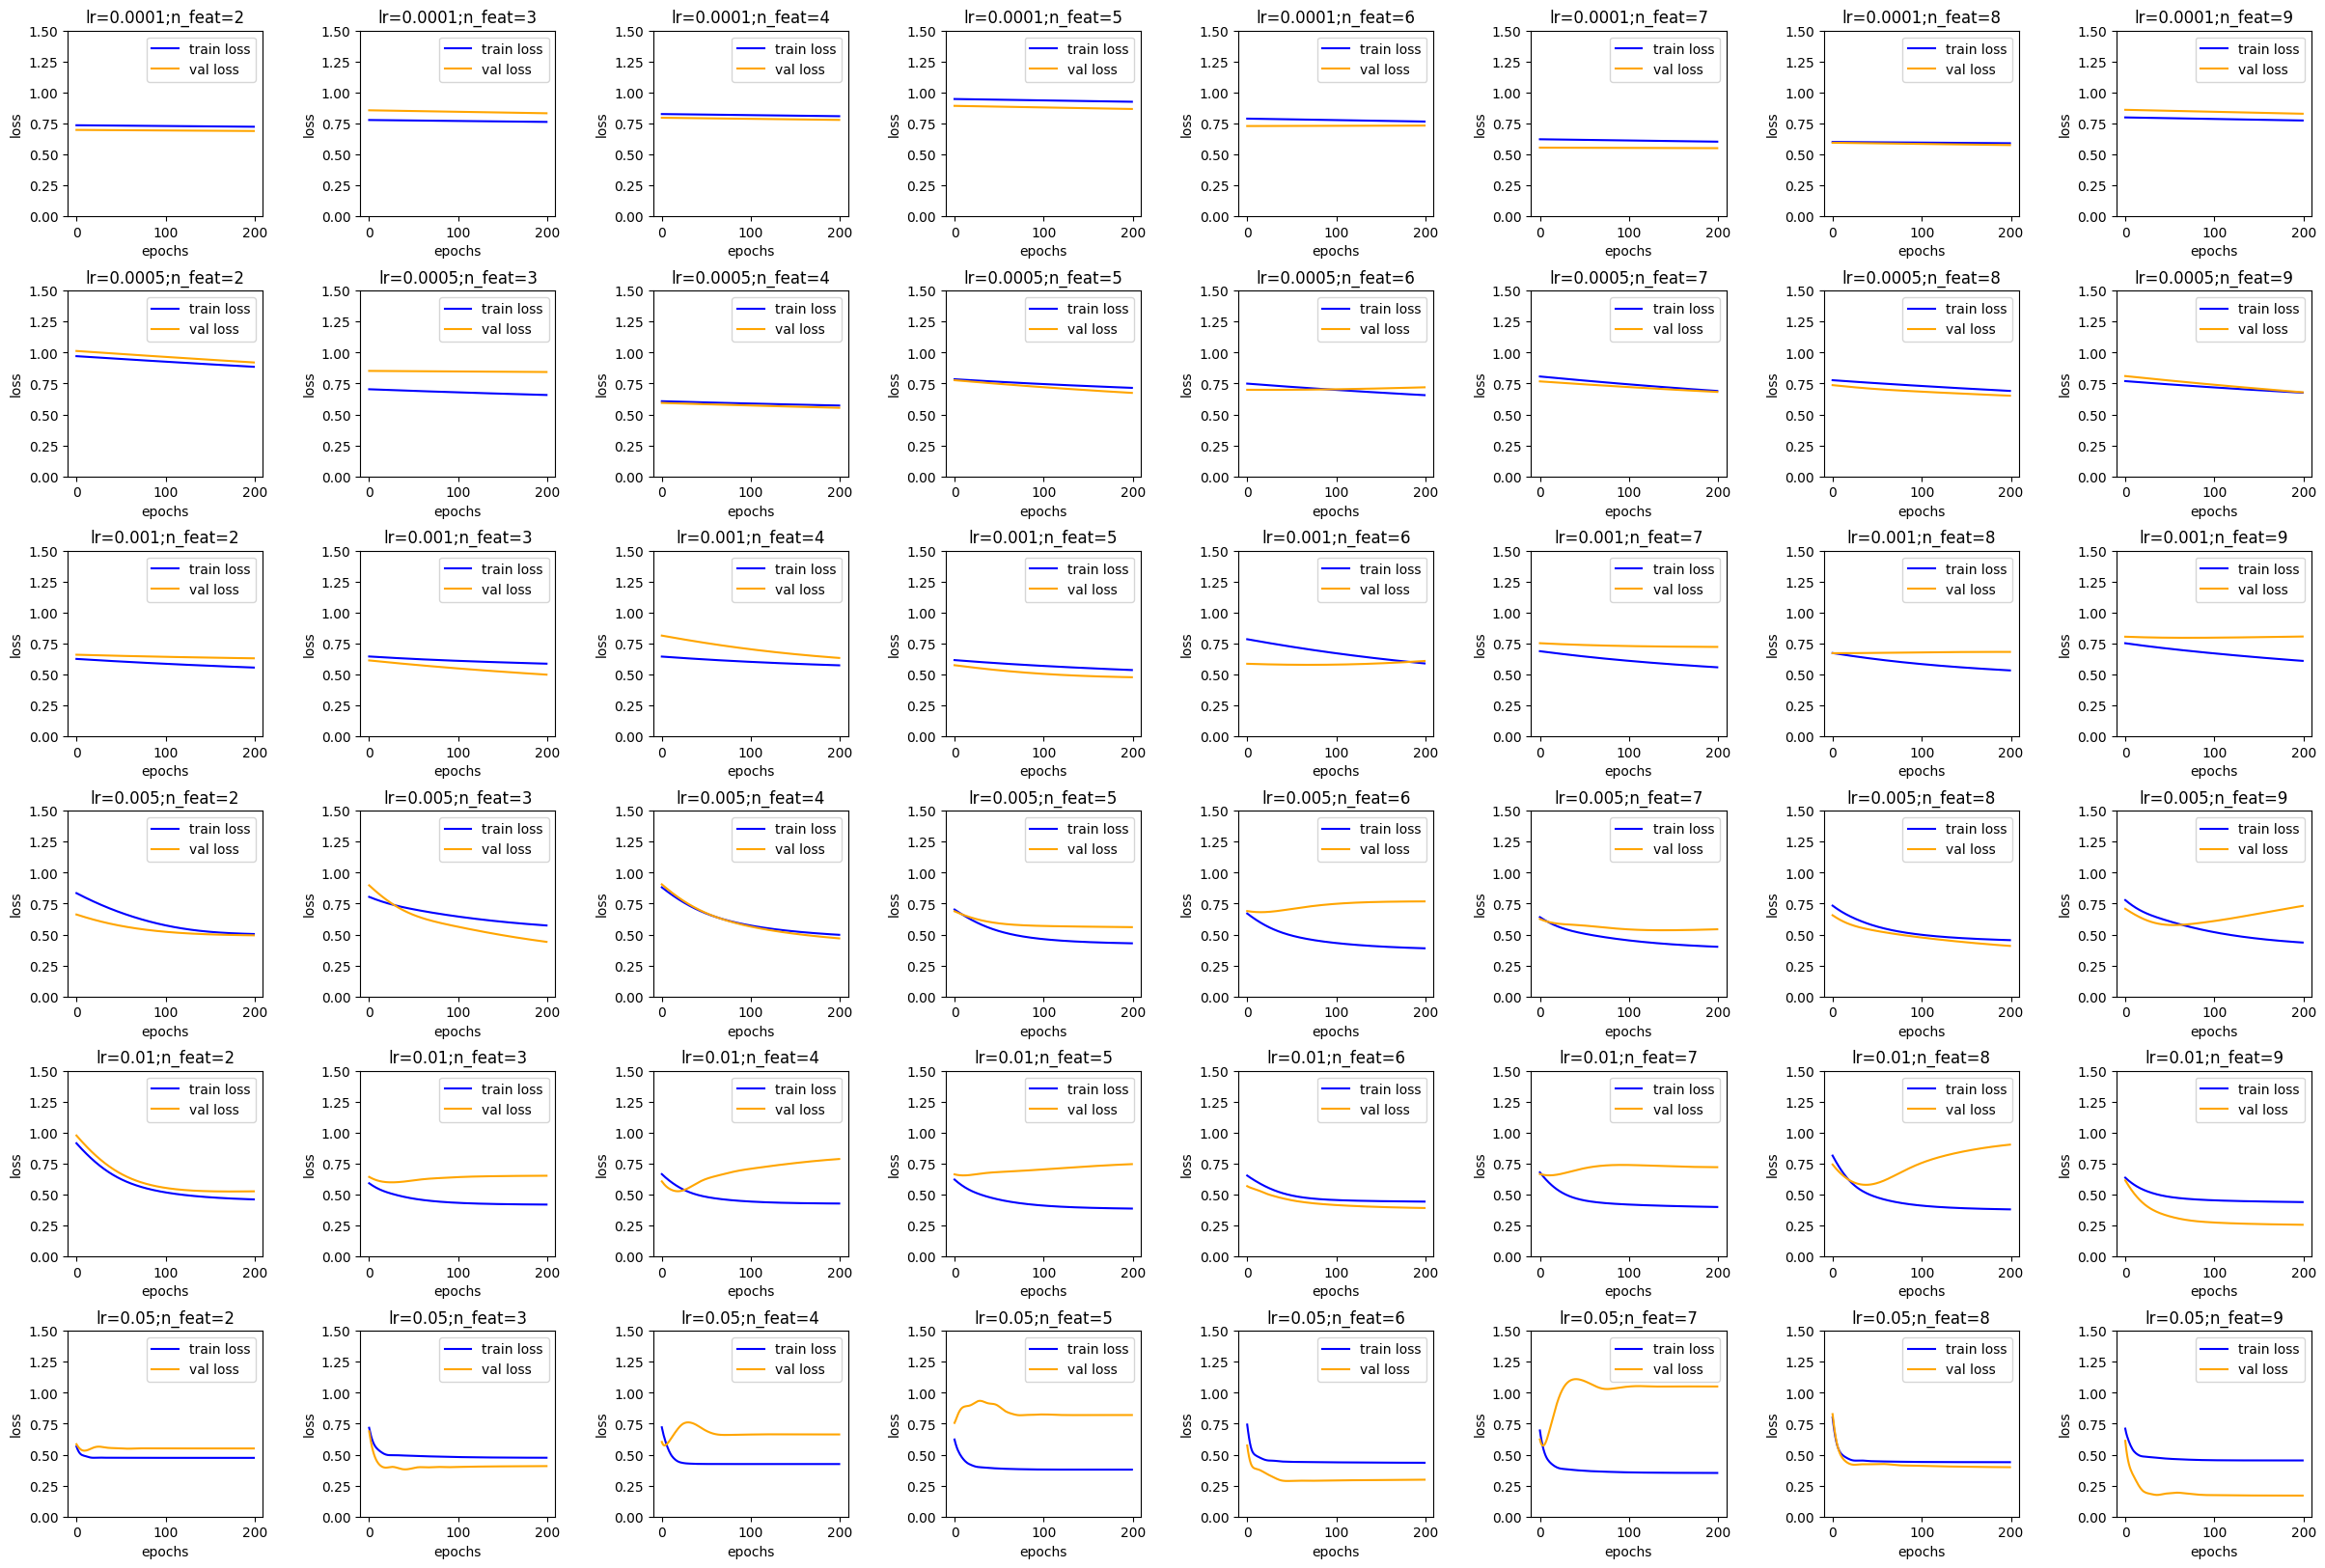

In [20]:
epochs = [n for n in range(n_epochs)]

fig, ax = plt.subplots(len(lr_values),len(n_features_values),figsize=(30,20))

for i in range(len(lr_values)):

    for j in range(len(n_features_values)):

        ax[i,j].plot(epochs, train_losses[(lr_values[i], n_features_values[j])],color='blue',label='train loss')
        ax[i,j].plot(epochs, val_losses[(lr_values[i], n_features_values[j])],color='orange',label='val loss')
        ax[i,j].set_ylim((0,1.5))
        ax[i,j].set_xlabel('epochs')
        ax[i,j].set_ylabel('loss')
        ax[i,j].set_title(f'lr={lr_values[i]};n_feat={n_features_values[j]}')
        ax[i,j].legend()

plt.subplots_adjust(hspace=0.4, wspace=0.5)

### 2. GCN

In [24]:
train_losses, val_losses = {},{}
lr = 0.005
group = df["Tumour type"].to_numpy()

for max_neighbors in max_neighbors_values:

    for n_features in n_features_values:

        # Feature selection
        features_name_selection = FeatureSelector.feature_importance(df.loc[:, features_name], y, False)
        if n_features < len(features_name):
            features_name_selection = features_name_selection[:n_features]
        X = df.loc[:, features_name_selection].to_numpy()
        
        # Build graph 
        distance_matrix = euclidean_distances(X)
        graph_builder = GraphBuilder(X, y, group)
        graph_builder.build_graph(distance_matrix, max_neighbors, True)
        nx_graph = graph_builder.nx_graph

        # Train
        gcn_manager = GNNClassifierTrainTestManager('gcn')
        gcn_manager.model = GCNClassifier(n_features)
        train_index = [i for i in range(X.shape[0])]
        train_loss_list, val_loss_list = gcn_manager.train(nx_graph, n_epochs, lr, reg, train_index)

        # Add to memory
        train_losses[(max_neighbors, n_features)] = train_loss_list
        val_losses[(max_neighbors, n_features)] = val_loss_list

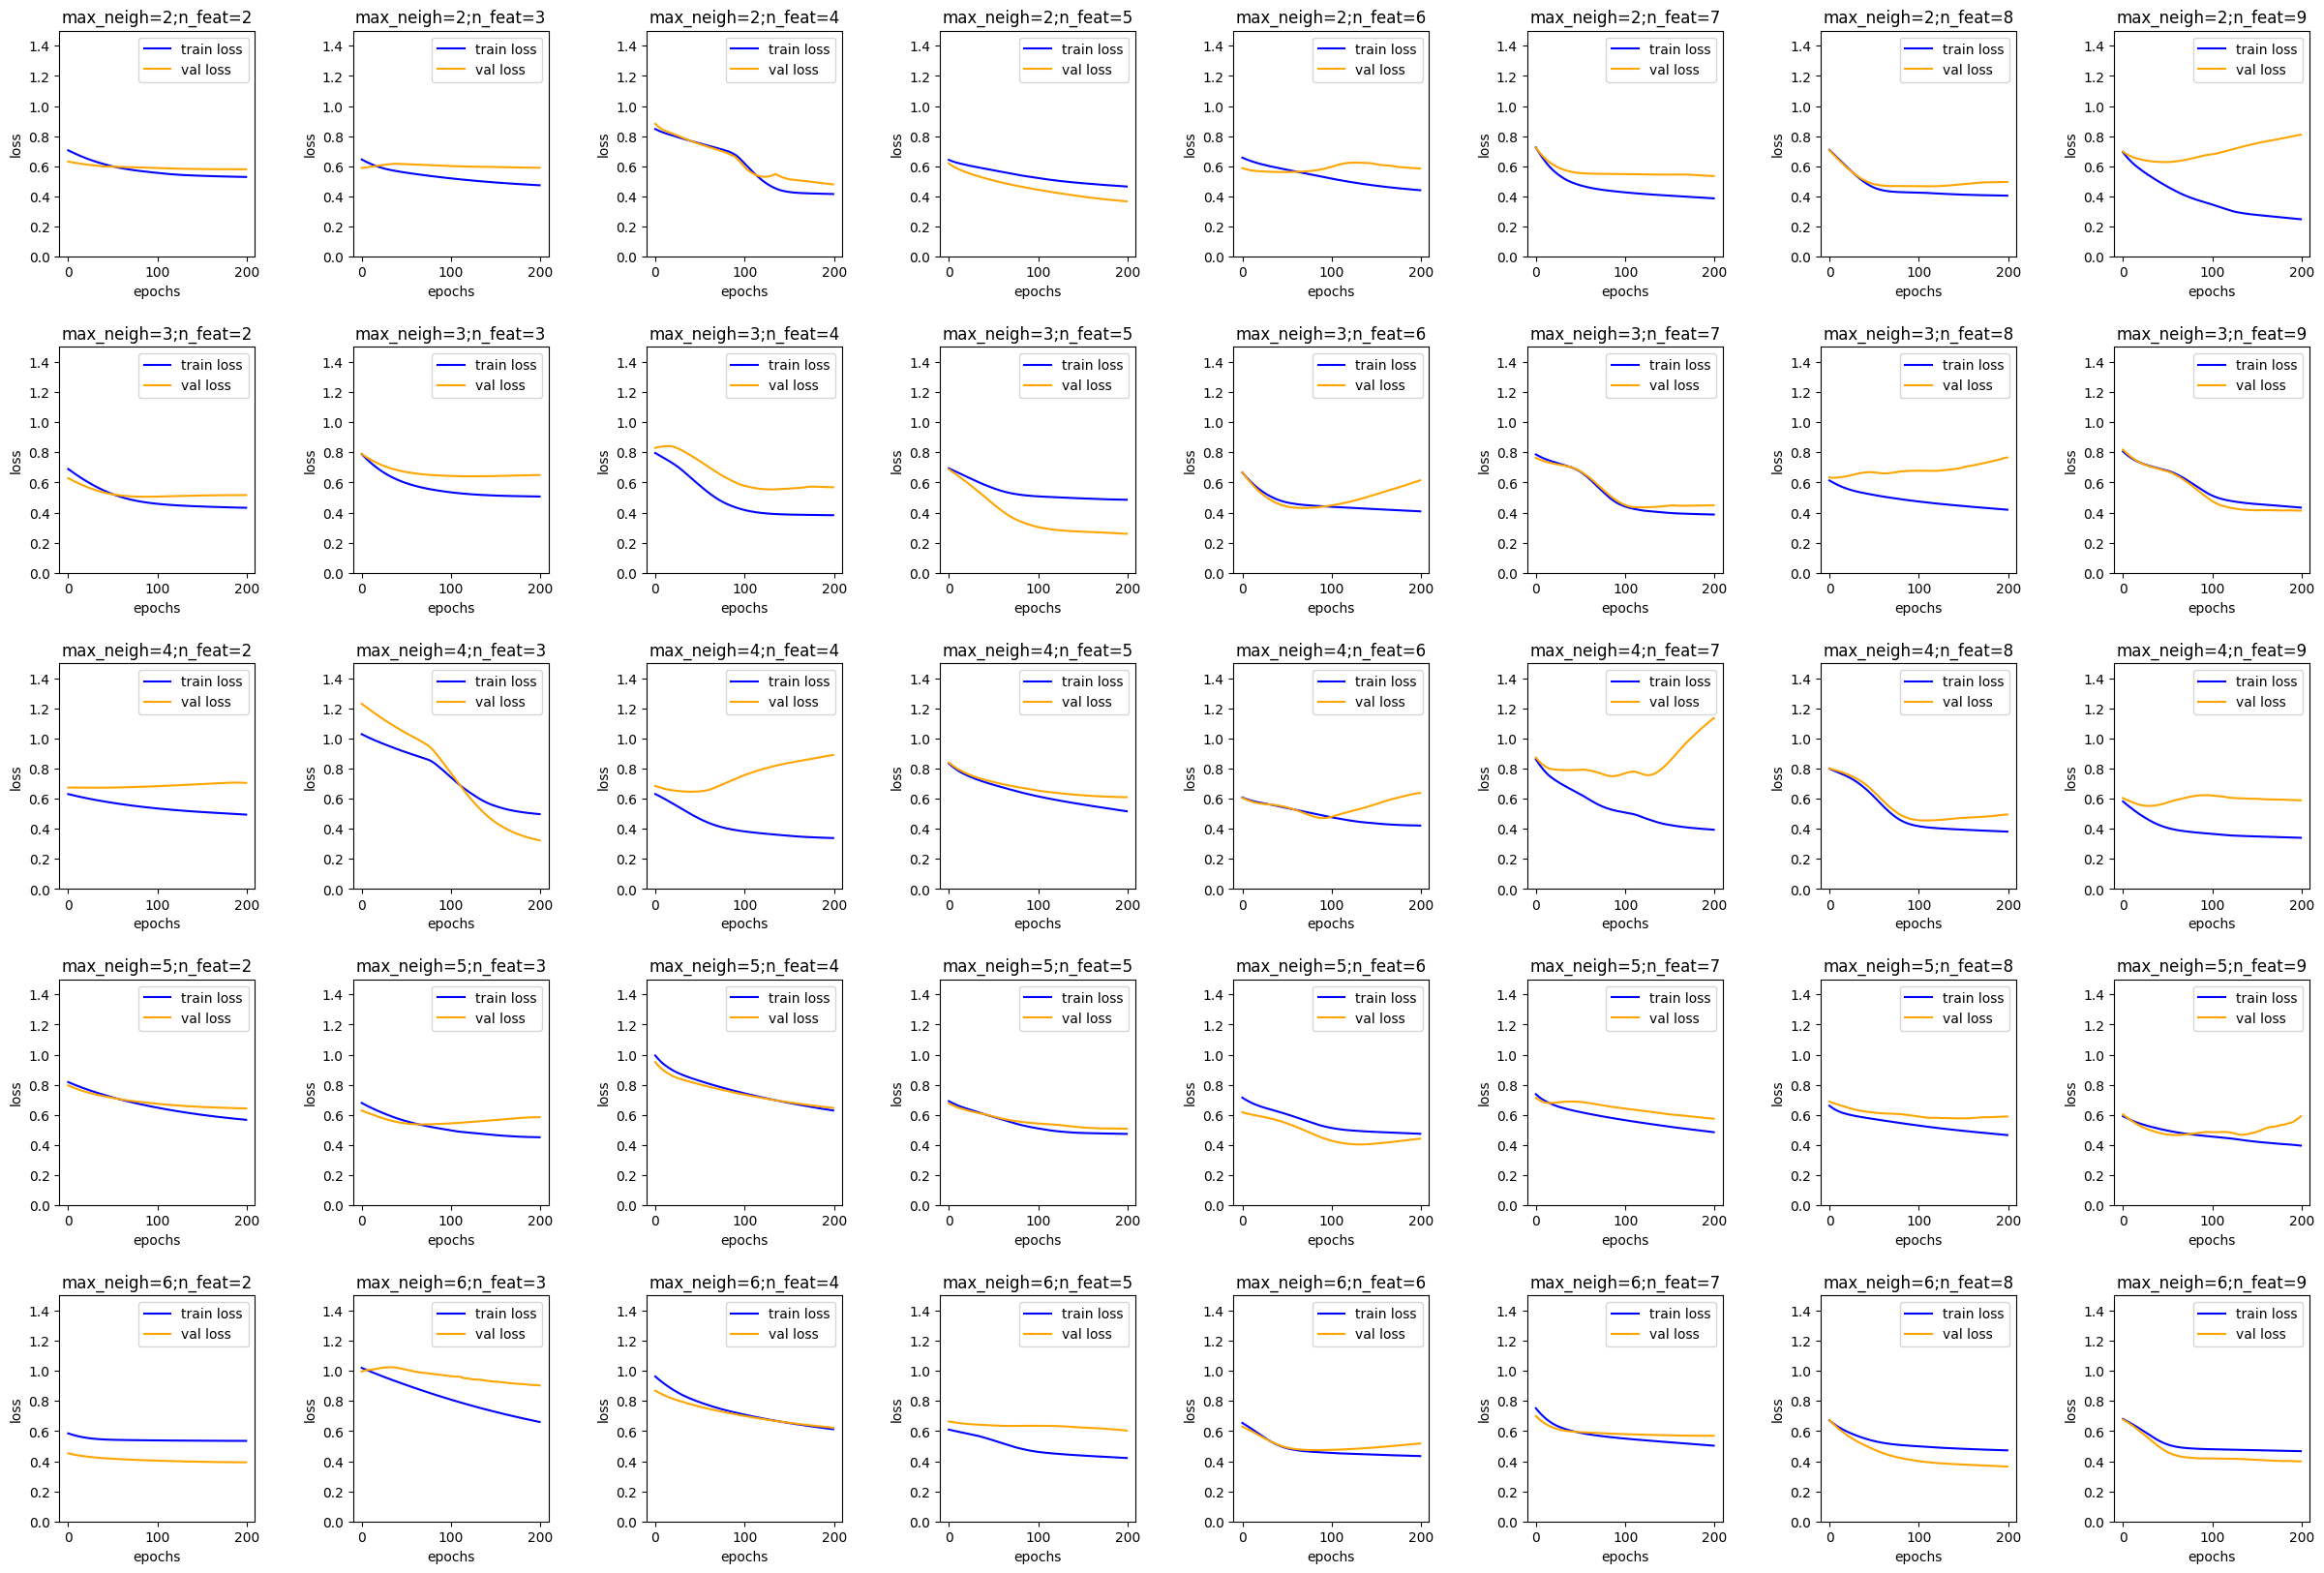

In [25]:
epochs = [n for n in range(n_epochs)]

fig, ax = plt.subplots(len(max_neighbors_values),len(n_features_values),figsize=(30,20))

for i in range(len(max_neighbors_values)):

    for j in range(len(n_features_values)):

        ax[i,j].plot(epochs, train_losses[(max_neighbors_values[i], n_features_values[j])],color='blue',label='train loss')
        ax[i,j].plot(epochs, val_losses[(max_neighbors_values[i], n_features_values[j])],color='orange',label='val loss')
        ax[i,j].set_ylim((0,1.5))
        ax[i,j].set_xlabel('epochs')
        ax[i,j].set_ylabel('loss')
        ax[i,j].set_title(f'max_neigh={max_neighbors_values[i]};n_feat={n_features_values[j]}')
        ax[i,j].legend()

plt.subplots_adjust(hspace=0.4, wspace=0.5)